# Assignment 4 - Average Reward Softmax Actor-Critic

Welcome to your Course 3 Programming Assignment 4. In this assignment, you will implement **Average Reward Softmax Actor-Critic** in the Pendulum Swing-Up problem that you have seen earlier in the lecture. Through this assignment you will get hands-on experience in implementing actor-critic methods on a continuing task.

**In this assignment, you will:**
    1. Implement softmax actor-critic agent on a continuing task using the average reward formulation.
    2. Understand how to parameterize the policy as a function to learn, in a discrete action environment.
    3. Understand how to (approximately) sample the gradient of this objective to update the actor.
    4. Understand how to update the critic using differential TD error.


## Pendulum Swing-Up Environment

In this assignment, we will be using a Pendulum environment, adapted from [Santamaría et al. (1998)](http://www.incompleteideas.net/papers/SSR-98.pdf). This is also the same environment that we used in the lecture. The diagram below illustrates the environment.

<img src="data/pendulum_env.png" alt="Drawing" style="width: 400px;"/>

The environment consists of single pendulum that can swing 360 degrees. The pendulum is actuated by applying a torque on its pivot point. The goal is to get the pendulum to balance up-right from its resting position (hanging down at the bottom with no velocity) and maintain it as long as possible. The pendulum can move freely, subject only to gravity and the action applied by the agent. 

The state is 2-dimensional, which consists of the current angle $\beta \in [-\pi, \pi]$ (angle from the vertical upright position) and current angular velocity $\dot{\beta} \in (-2\pi, 2\pi)$. The angular velocity is constrained in order to avoid damaging the pendulum system. If the angular velocity reaches this limit during simulation, the pendulum is reset to the resting position. 
The action is the angular acceleration, with discrete values $a \in \{-1, 0, 1\}$ applied to the pendulum.
For more details on environment dynamics you can refer to the original paper.

The goal is to swing-up the pendulum and maintain its upright angle. Hence, the reward is the negative absolute angle from the vertical position: $R_{t} = -|\beta_{t}|$

Furthermore, since the goal is to reach and maintain a vertical position, there are no terminations nor episodes. Thus this problem can be formulated as a continuing task.

Similar to the Mountain Car task, the action in this pendulum environment is not strong enough to move the pendulum directly to the desired position. The agent must learn to first move the pendulum away from its desired position and gain enough momentum to successfully swing-up the pendulum. And even after reaching the upright position the agent must learn to continually balance the pendulum in this unstable position.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html) : Library for reinforcement learning experiments.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments
- plot_script : custom script to plot results
- [tiles3](http://incompleteideas.net/tiles/tiles3.html) : A package that implements tile-coding.
- pendulum_env : Pendulum Swing-up Environment

**Please do not import other libraries** — this will break the autograder.


In [1]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import itertools
from tqdm import tqdm

from rl_glue import RLGlue
from pendulum_env import PendulumEnvironment
from agent import BaseAgent
import plot_script
import tiles3 as tc

## Section 1: Create Tile Coding Helper Function

In this section, we are going to build a tile coding class for our agent that will make it easier to make calls to our tile coder.

Tile-coding is introduced in Section 9.5.4 of the textbook as a way to create features that can both provide good generalization and discrimination. We have already used it in our last programming assignment as well. 

Similar to the last programming assignment, we are going to make a function specific for tile coding for our Pendulum Swing-up environment. We will also use the [Tiles3 library](http://incompleteideas.net/tiles/tiles3.html).

To get the tile coder working we need to:

    1) create an index hash table using tc.IHT(), 
    2) scale the inputs for the tile coder based on number of tiles and range of values each input could take
    3) call tc.tileswrap to get active tiles back.

However, we need to make one small change to this tile coder.
Note that in this environment the state space contains angle, which is between $[-\pi, \pi]$. If we tile-code this state space in the usual way, the agent may think the value of states corresponding to an angle of $-\pi$ is very different from angle of $\pi$ when in fact they are the same! To remedy this and allow generalization between angle $= -\pi$ and angle $= \pi$, we need to use **wrap tile coder**.

The usage of wrap tile coder is almost identical to the original tile coder, except that we also need to provide the `wrapwidth` argument for the dimension we want to wrap over (hence only for angle, and `None` for angular velocity). More details of wrap tile coder is also provided in [Tiles3 library](http://incompleteideas.net/tiles/tiles3.html).


In [2]:
# -----------
# Graded Cell
# -----------
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same
                            
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles 
        self.iht = tc.IHT(iht_size)
    
    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.
        
        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -2*np.pi and 2*np.pi
        
        returns:
        tiles -- np.array, active tiles
        
        """
        
        ### Use the ranges above and scale the angle and angular velocity between [0, 1]
        # then multiply by the number of tiles so they are scaled between [0, self.num_tiles]
        angle_scaled = self.num_tiles * (angle - -np.pi) / (np.pi - -np.pi)
        ang_vel_scaled = self.num_tiles * (ang_vel - -2*np.pi) / (2*np.pi - -2*np.pi)
        
        # ----------------
        
        
        # ----------------
        
        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle_scaled, ang_vel_scaled], wrapwidths=[self.num_tiles, False])
                    
        return np.array(tiles)

Run the following code to verify `PendulumTilecoder`

In [3]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

## Test Code for PendulumTileCoder ##
# Your tile coder should also work for other num. tilings and num. tiles
angles = np.linspace(-np.pi, np.pi, num=5)
vels = np.linspace(-2 * np.pi, 2 * np.pi, num=5)
test_obs = list(itertools.product(angles, vels))

pdtc = PendulumTileCoder(iht_size=4096, num_tilings=8, num_tiles=2)

result=[]
for obs in test_obs:
    angle, ang_vel = obs
    tiles = pdtc.get_tiles(angle=angle, ang_vel=ang_vel)
    result.append(tiles)
    
expected = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 8, 3, 9, 10, 6, 11],
    [12, 13, 8, 14, 9, 10, 15, 11],
    [12, 13, 16, 14, 17, 18, 15, 19],
    [20, 21, 16, 22, 17, 18, 23, 19],
    [0, 1, 2, 3, 24, 25, 26, 27],
    [0, 1, 8, 3, 28, 29, 26, 30],
    [12, 13, 8, 14, 28, 29, 31, 30],
    [12, 13, 16, 14, 32, 33, 31, 34],
    [20, 21, 16, 22, 32, 33, 35, 34],
    [36, 37, 38, 39, 24, 25, 26, 27],
    [36, 37, 40, 39, 28, 29, 26, 30],
    [41, 42, 40, 43, 28, 29, 31, 30],
    [41, 42, 44, 43, 32, 33, 31, 34],
    [45, 46, 44, 47, 32, 33, 35, 34],
    [36, 37, 38, 39, 4, 5, 6, 7],
    [36, 37, 40, 39, 9, 10, 6, 11],
    [41, 42, 40, 43, 9, 10, 15, 11],
    [41, 42, 44, 43, 17, 18, 15, 19],
    [45, 46, 44, 47, 17, 18, 23, 19],
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 8, 3, 9, 10, 6, 11],
    [12, 13, 8, 14, 9, 10, 15, 11],
    [12, 13, 16, 14, 17, 18, 15, 19],
    [20, 21, 16, 22, 17, 18, 23, 19],
])

assert np.all(expected == np.array(result))

## Section 2: Create Average Reward Softmax Actor-Critic Agent

Now that we implemented PendulumTileCoder let's create the agent that interacts with the environment. We will implement the same average reward Actor-Critic algorithm presented in the videos.

This agent has two components: an Actor and a Critic. The Actor learns a parameterized policy while the Critic learns a state-value function. The environment has discrete actions; your Actor implementation will use a softmax policy with exponentiated action-preferences. The Actor learns with the sample-based estimate for the gradient of the average reward objective. The Critic learns using the average reward version of the semi-gradient TD(0) algorithm.

In this section, you will be implementing `agent_policy`, `agent_start`, `agent_step`, and `agent_end`.

## Section 2-1: Implement Helper Functions

Let's first define a couple of useful helper functions.

## Section 2-1a: Compute Softmax Probability

In this part you will implement `compute_softmax_prob`.

This function computes softmax probability for all actions, given actor weights `actor_w` and active tiles `tiles`. This function will be later used in `agent_policy` to sample appropriate action.

First, recall how the softmax policy is represented from state-action preferences: $\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}}$.

**state-action preference** is defined as $h(s,a, \mathbf{\theta}) \doteq \mathbf{\theta}^T \mathbf{x}_h(s,a)$.

Given active tiles `tiles` for state `s`, state-action preference $\mathbf{\theta}^T \mathbf{x}_h(s,a)$ can be computed by `actor_w[a][tiles].sum()`.

We will also use **exp-normalize trick**, in order to avoid possible numerical overflow. 
Consider the following:

$\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}} = \frac{e^{h(s,a,\mathbf{\theta}) - c} e^c}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c} e^c} = \frac{e^{h(s,a,\mathbf{\theta}) - c}}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c}}$ 

$\pi(\cdot|s, \mathbf{\theta})$ is shift-invariant, and the policy remains the same when we subtract a constant $c \in \mathbb{R}$ from state-action preferences.

Normally we use $c = \max_b h(s,b, \mathbf{\theta})$, to prevent any overflow due to exponentiating large numbers.

In [4]:
# -----------
# Graded Cell
# -----------

def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions
    
    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles
    
    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """
    
    # First compute the list of state-action preferences (1~2 lines)
    # state_action_preferences = ? (list of size 3)
    state_action_preferences = []
    # ----------------
    state_action_preferences = actor_w[:, tiles].sum(axis=1)
    
    # ----------------
    
    # Set the constant c by finding the maximum of state-action preferences (use np.max) (1 line)
    # c = ? (float)
    # ----------------
    c = np.max(state_action_preferences)
    
    # ----------------
    
    # Compute the numerator by subtracting c from state-action preferences and exponentiating it (use np.exp) (1 line)
    # numerator = ? (list of size 3)
    # ----------------
    numerator = np.exp(state_action_preferences - c)
    
    # ----------------
    
    # Next compute the denominator by summing the values in the numerator (use np.sum) (1 line)
    # denominator = ? (float)
    # ----------------
    denominator = np.sum(numerator)
    
    # ----------------
    
    
    # Create a probability array by dividing each element in numerator array by denominator (1 line)
    # We will store this probability array in self.softmax_prob as it will be useful later when updating the Actor
    # softmax_prob = ? (list of size 3)
    # ----------------
    softmax_prob = numerator / denominator
    
    # ----------------
    
    return softmax_prob

Run the following code to verify `compute_softmax_prob`.

We will test the method by building a softmax policy from state-action preferences [-1,1,2].

The sampling probability should then roughly match $[\frac{e^{-1}}{e^{-1}+e^1+e^2}, \frac{e^{1}}{e^{-1}+e^1+e^2}, \frac{e^2}{e^{-1}+e^1+e^2}] \approx$ [0.0351, 0.2595, 0.7054]

In [5]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# set tile-coder
iht_size = 4096
num_tilings = 8
num_tiles = 8
test_tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

num_actions = 3
actions = list(range(num_actions))
actor_w = np.zeros((len(actions), iht_size))

# setting actor weights such that state-action preferences are always [-1, 1, 2]
actor_w[0] = -1./num_tilings
actor_w[1] = 1./num_tilings
actor_w[2] = 2./num_tilings

# obtain active_tiles from state
state = [-np.pi, 0.]
angle, ang_vel = state
active_tiles = test_tc.get_tiles(angle, ang_vel)

# compute softmax probability
softmax_prob = compute_softmax_prob(actor_w, active_tiles) 
print('softmax probability: {}'.format(softmax_prob))

assert np.allclose(softmax_prob, [0.03511903, 0.25949646, 0.70538451])

softmax probability: [0.03511903 0.25949646 0.70538451]


## Section 2-2: Implement Agent Methods

Let's first define methods that initialize the agent. `agent_init()` initializes all the variables that the agent will need.

Now that we have implemented helper functions, let's create an agent. In this part, you will implement `agent_start()` and `agent_step()`. We do not need to implement `agent_end()` because there is no termination in our continuing task. 

`compute_softmax_prob()` is used in `agent_policy()`, which in turn will be used in `agent_start()` and `agent_step()`. We have implemented `agent_policy()` for you.

When performing updates to the Actor and Critic, recall their respective updates in the Actor-Critic algorithm video.

We approximate $q_\pi$ in the Actor update using one-step bootstrapped return($R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w})$) subtracted by current state-value($\hat{v}(S_{t}, \mathbf{w})$), equivalent to TD error $\delta$.

$\delta_t = R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em} (1)$

**Average Reward update rule**: $\bar{R} \leftarrow \bar{R} + \alpha^{\bar{R}}\delta \hspace{4.3em} (2)$

**Critic weight update rule**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em} (3)$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em} (4)$


However, since we are using linear function approximation and parameterizing a softmax policy, the above update rule can be further simplified using:

$\nabla \hat{v}(s,\mathbf{w}) = \mathbf{x}(s) \hspace{14.2em} (5)$

$\nabla ln \pi(A|S,\mathbf{\theta}) = \mathbf{x}_h(s,a) - \sum_b \pi(b|s, \mathbf{\theta})\mathbf{x}_h(s,b) \hspace{3.3em} (6)$


In [6]:
# -----------
# Graded Cell
# -----------

class ActorCriticSoftmaxAgent(BaseAgent): 
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            "iht_size": int
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        # set random seed for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        # initialize self.tc to the tile coder we created
        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        # set step-size accordingly (we normally divide actor and critic step-size by num. tilings (p.217-218 of textbook))
        self.actor_step_size = agent_info.get("actor_step_size")/num_tilings
        self.critic_step_size = agent_info.get("critic_step_size")/num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        # Set initial values of average reward, actor weights, and critic weights
        # We initialize actor weights to three times the iht_size. 
        # Recall this is because we need to have one set of weights for each of the three actions.
        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), iht_size))
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_policy(self, active_tiles):
        """ policy of the agent
        Args:
            active_tiles (Numpy array): active tiles returned by tile coder
            
        Returns:
            The action selected according to the policy
        """
        
        # compute softmax probability
        softmax_prob = compute_softmax_prob(self.actor_w, active_tiles)
        
        # Sample action from the softmax probability array
        # self.rand_generator.choice() selects an element from the array with the specified probability
        chosen_action = self.rand_generator.choice(self.actions, p=softmax_prob)
        
        # save softmax_prob as it will be useful later when updating the Actor
        self.softmax_prob = softmax_prob
        
        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """

        angle, ang_vel = state

        ### Use self.tc to get active_tiles using angle and ang_vel (2 lines)
        # set current_action by calling self.agent_policy with active_tiles
        # active_tiles = ?
        # current_action = ?

        # ----------------
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        current_action = self.agent_policy(active_tiles)
        # ----------------

        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based on 
                                where the agent ended up after the
                                last step.
        Returns:
            The action the agent is taking.
        """

        angle, ang_vel = state

        ### Use self.tc to get active_tiles using angle and ang_vel (1 line)
        # active_tiles = ?    
        # ----------------
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        
        # ----------------

        ### Compute delta using Equation (1) (1 line)
        # delta = ?
        # ----------------
        delta = reward - self.avg_reward + self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum()
        
        # ----------------

        ### update average reward using Equation (2) (1 line)
        # self.avg_reward += ?
        # ----------------
        self.avg_reward += self.avg_reward_step_size * delta
        
        # ----------------

        # update critic weights using Equation (3) and (5) (1 line)
        # self.critic_w[self.prev_tiles] += ?
        # ----------------
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta
        
        # ----------------

        # update actor weights using Equation (4) and (6)
        # We use self.softmax_prob saved from the previous timestep
        # We leave it as an exercise to verify that the code below corresponds to the equation.
        for a in self.actions:
            if a == self.last_action:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
            else:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        ### set current_action by calling self.agent_policy with active_tiles (1 line)
        # current_action = ? 
        # ----------------
        current_action = self.agent_policy(active_tiles)
        
        # ----------------

        self.prev_tiles = active_tiles
        self.last_action = current_action

        return self.last_action


    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward


Run the following code to verify `agent_start()`.
Although there is randomness due to `self.rand_generator.choice()` in `agent_policy()`, we control the seed so your output should match the expected output. 

In [7]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
    "iht_size": 4096,
    "num_tilings": 8,
    "num_tiles": 8,
    "actor_step_size": 1e-1,
    "critic_step_size": 1e-0,
    "avg_reward_step_size": 1e-2,
    "num_actions": 3,
    "seed": 99,
}

test_agent = ActorCriticSoftmaxAgent()
test_agent.agent_init(agent_info)

state = [-np.pi, 0.]

test_agent.agent_start(state)

assert np.all(test_agent.prev_tiles == [0, 1, 2, 3, 4, 5, 6, 7])
assert test_agent.last_action == 2

print("agent active_tiles: {}".format(test_agent.prev_tiles))
print("agent selected action: {}".format(test_agent.last_action))


agent active_tiles: [0 1 2 3 4 5 6 7]
agent selected action: 2


Run the following code to verify `agent_step()`

In [8]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# Make sure agent_start() and agent_policy() are working correctly first.
# agent_step() should work correctly for other arbitrary state transitions in addition to this test case.

env_info = {"seed": 99}
agent_info = {
    "iht_size": 4096,
    "num_tilings": 8,
    "num_tiles": 8,
    "actor_step_size": 1e-1,
    "critic_step_size": 1e-0,
    "avg_reward_step_size": 1e-2,
    "num_actions": 3,
    "seed": 99,
}

rl_glue = RLGlue(PendulumEnvironment, ActorCriticSoftmaxAgent)
rl_glue.rl_init(agent_info, env_info)

# start env/agent
rl_glue.rl_start()
rl_glue.rl_step()

# simple alias
agent = rl_glue.agent

print("agent next_action: {}".format(agent.last_action))
print("agent avg reward: {}\n".format(agent.avg_reward))

assert agent.last_action == 1
assert agent.avg_reward == -0.03139092653589793

print("agent first 10 values of actor weights[0]: \n{}\n".format(agent.actor_w[0][:10]))
print("agent first 10 values of actor weights[1]: \n{}\n".format(agent.actor_w[1][:10]))
print("agent first 10 values of actor weights[2]: \n{}\n".format(agent.actor_w[2][:10]))
print("agent first 10 values of critic weights: \n{}".format(agent.critic_w[:10]))

assert np.allclose(agent.actor_w[0][:10], [0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0., 0.])
assert np.allclose(agent.actor_w[1][:10], [0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0., 0.])
assert np.allclose(agent.actor_w[2][:10], [-0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, 0., 0.])

assert np.allclose(agent.critic_w[:10], [-0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, 0., 0.])

agent next_action: 1
agent avg reward: -0.03139092653589793

agent first 10 values of actor weights[0]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[1]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[2]: 
[-0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911
 -0.02615911 -0.02615911  0.          0.        ]

agent first 10 values of critic weights: 
[-0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658
 -0.39238658 -0.39238658  0.          0.        ]


## Section 3: Run Experiment

Now that we've implemented all the components of environment and agent, let's run an experiment! 
We want to see whether our agent is successful at learning the optimal policy of balancing the pendulum upright. We will plot total return over time, as well as the exponential average of the reward over time. We also do multiple runs in order to be confident about our results.  

The experiment/plot code is provided in the cell below.

In [9]:
# ---------------
# Discussion Cell
# ---------------

# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)
            
    # sweep agent parameters
    for num_tilings in agent_parameters['num_tilings']:
        for num_tiles in agent_parameters["num_tiles"]:
            for actor_ss in agent_parameters["actor_step_size"]:
                for critic_ss in agent_parameters["critic_step_size"]:
                    for avg_reward_ss in agent_parameters["avg_reward_step_size"]:
                        
                        env_info = {}
                        agent_info = {"num_tilings": num_tilings,
                                      "num_tiles": num_tiles,
                                      "actor_step_size": actor_ss,
                                      "critic_step_size": critic_ss,
                                      "avg_reward_step_size": avg_reward_ss,
                                      "num_actions": agent_parameters["num_actions"],
                                      "iht_size": agent_parameters["iht_size"]}            
            
                        # results to save
                        return_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))
                        exp_avg_reward_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))

                        # using tqdm we visualize progress bars 
                        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                            env_info["seed"] = run
                            agent_info["seed"] = run
                
                            rl_glue.rl_init(agent_info, env_info)
                            rl_glue.rl_start()

                            num_steps = 0
                            total_return = 0.
                            return_arr = []

                            # exponential average reward without initial bias
                            exp_avg_reward = 0.0
                            exp_avg_reward_ss = 0.01
                            exp_avg_reward_normalizer = 0

                            while num_steps < experiment_parameters['max_steps']:
                                num_steps += 1
                                
                                rl_step_result = rl_glue.rl_step()
                                
                                reward = rl_step_result[0]
                                total_return += reward
                                return_arr.append(reward)
                                avg_reward = rl_glue.rl_agent_message("get avg reward")

                                exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
                                ss = exp_avg_reward_ss / exp_avg_reward_normalizer
                                exp_avg_reward += ss * (reward - exp_avg_reward)
                                
                                return_per_step[run-1][num_steps-1] = total_return
                                exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward
                                                        
                        if not os.path.exists('results'):
                            os.makedirs('results')
                
                        save_name = "ActorCriticSoftmax_tilings_{}_tiledim_{}_actor_ss_{}_critic_ss_{}_avg_reward_ss_{}".format(num_tilings, num_tiles, actor_ss, critic_ss, avg_reward_ss)
                        total_return_filename = "results/{}_total_return.npy".format(save_name)
                        exp_avg_reward_filename = "results/{}_exp_avg_reward.npy".format(save_name)

                        np.save(total_return_filename, return_per_step)
                        np.save(exp_avg_reward_filename, exp_avg_reward_per_step)
                        

## Section 3-1: Run Experiment with 32 tilings, size 8x8

We will first test our implementation using 32 tilings, of size 8x8. We saw from the earlier assignment using tile-coding that many tilings promote fine discrimination, and broad tiles allows more generalization.
We conducted a wide sweep of meta-parameters in order to find the best meta-parameters for our Pendulum Swing-up task. 

We swept over the following range of meta-parameters and the best meta-parameter is boldfaced below:

actor step-size: $\{\frac{2^{-6}}{32}, \frac{2^{-5}}{32}, \frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \mathbf{\frac{2^{-2}}{32}}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \frac{2^{1}}{32}\}$

critic step-size: $\{\frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \frac{2^{-2}}{32}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \mathbf{\frac{2^{1}}{32}}, \frac{3}{32}, \frac{2^{2}}{32}\}$

avg reward step-size: $\{2^{-11}, 2^{-10} , 2^{-9} , 2^{-8}, 2^{-7}, \mathbf{2^{-6}}, 2^{-5}, 2^{-4}, 2^{-3}, 2^{-2}\}$  


We will do 50 runs using the above best meta-parameter setting to verify your agent.
Note that running the experiment cell below will take **_approximately 5 min_**.


100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


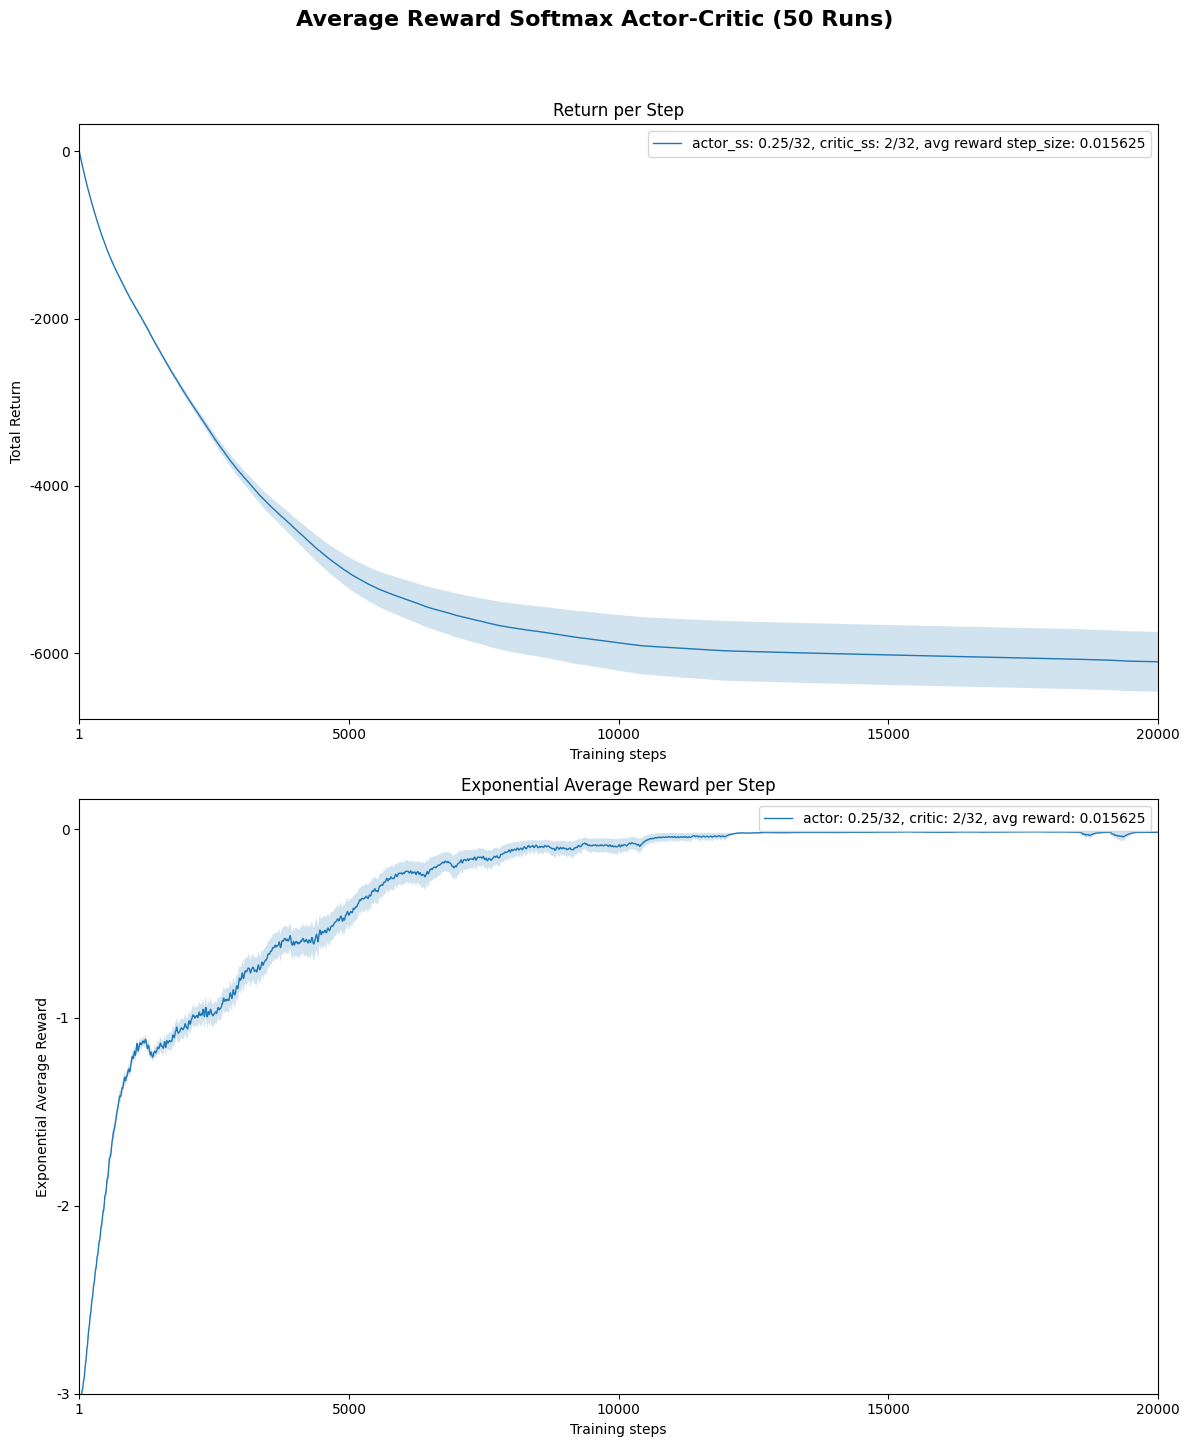

In [10]:
# ---------------
# Discussion Cell
# ---------------

#### Run Experiment

# Experiment parameters
experiment_parameters = {
    "max_steps" : 20000,
    "num_runs" : 50
}

# Environment parameters
environment_parameters = {}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
# actor and critic step-sizes are divided by num. tilings inside the agent
agent_parameters = {
    "num_tilings": [32],
    "num_tiles": [8],
    "actor_step_size": [2**(-2)],
    "critic_step_size": [2**1],
    "avg_reward_step_size": [2**(-6)],
    "num_actions": 3,
    "iht_size": 4096
}

current_env = PendulumEnvironment
current_agent = ActorCriticSoftmaxAgent


run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

Run the following code to verify your experimental result.

In [11]:
# ---------------
# Discussion Cell
# ---------------

## Test Code for experimental result ##
filename = 'ActorCriticSoftmax_tilings_32_tiledim_8_actor_ss_0.25_critic_ss_2_avg_reward_ss_0.015625_exp_avg_reward'
agent_exp_avg_reward = np.load('results/{}.npy'.format(filename), allow_pickle=True)
result_med = np.median(agent_exp_avg_reward, axis=0)

answer_range = np.load('correct_npy/exp_avg_reward_answer_range.npy', allow_pickle=True)
upper_bound = answer_range.item()['upper-bound']
lower_bound = answer_range.item()['lower-bound']

# check if result is within answer range
all_correct = np.all(result_med <= upper_bound) and np.all(result_med >= lower_bound)

if all_correct:
    print("Your experiment results are correct!")
else:
    print("Your experiment results does not match with ours. Please check if you have implemented all methods correctly.")
    
    

Your experiment results are correct!


## Section 3-2: Performance Metric and Meta-Parameter Sweeps


### Performance Metric

To evaluate performance, we plotted both the return and exponentially weighted average reward over time. 

In the first plot, the return is negative because the reward is negative at every state except when the pendulum is in the upright position. As the policy improves over time, the agent accumulates less negative reward, and thus the return decreases slowly. Towards the end the slope is almost flat indicating the policy has stabilized to a good policy. When using this plot however, it can be difficult to distinguish whether it has learned an optimal policy. The near-optimal policy in this Pendulum Swing-up Environment is to maintain the pendulum in the upright position indefinitely, getting near 0 reward at each time step. We would have to examine the slope of the curve but it can be hard to compare the slope of different curves.

The second plot using exponential average reward gives a better visualization. We can see that towards the end the value is near 0, indicating it is getting near 0 reward at each time step. Here, the exponentially weighted average reward shouldn't be confused with the agent’s internal estimate of the average reward. To be more specific, we used an exponentially weighted average of the actual reward without initial bias (Refer to Exercise 2.7 from the textbook (p.35) to read more about removing the initial bias). If we used sample averages instead, later rewards would have decreasing impact on the average and would not be able to represent the agent's performance with respect to its current policy effectively.

It is easier to see whether the agent has learned a good policy in the second plot than the first plot. If the learned policy is optimal, the exponential average reward would be close to 0.

Furthermore, how did we pick the best meta-parameter from the sweeps? A common method would be to pick the meta-parameter that results in the largest Area Under the Curve (AUC). However, this is not always what we want. We want to find a set of meta-parameters that learns a good final policy. When using AUC as the criteria, we may pick meta-parameters that allows the agent to learn fast but converge to a worse policy. In our case, we selected the meta-parameter setting that obtained the most exponential average reward over the last 5000 time steps. 


### Parameter Sensitivity

In addition to finding the best meta-parameters it is also equally important to plot **parameter sensitivity curves** to understand how our algorithm behaves.

In our simulated Pendulum problem, we can extensively test our agent with different meta-parameter configurations but it would be quite expensive to do so in real life. Parameter sensitivity curves can provide us insight into how our algorithms might behave in general. It can help us identify a good range of each meta-parameters as well as how sensitive the performance is with respect to each meta-parameter.

Here are the sensitivity curves for the three step-sizes we swept over:

<img src="data/sensitivity_combined.png" alt="Drawing" style="width: 1000px;"/>

On the y-axis we use the performance measure, which is the average of the exponential average reward over the 5000 time steps, averaged over 50 different runs. On the x-axis is the meta-parameter we are testing. For the given meta-parameter, the remaining meta-parameters are chosen such that it obtains the best performance.

The curves are quite rounded, indicating the agent performs well for these wide range of values. It indicates that the agent is not too sensitive to these meta-parameters. Furthermore, looking at the y-axis values we can observe that average reward step-size is particularly less sensitive than actor step-size and critic step-size.

But how do we know that we have sufficiently covered a wide range of meta-parameters? It is important that the best value is not on the edge but in the middle of the meta-parameter sweep range in these sensitivity curves. Otherwise this may indicate that there could be better meta-parameter values that we did not sweep over.

## Wrapping up

### **Congratulations!** You have successfully implemented Course 3 Programming Assignment 4.


You have implemented your own **Average Reward Actor-Critic with Softmax Policy** agent in the Pendulum Swing-up Environment. You implemented the environment based on information about the state/action space and transition dynamics. Furthermore, you have learned how to implement an agent in a continuing task using the average reward formulation. We parameterized the policy using softmax of action-preferences over discrete action spaces, and used Actor-Critic to learn the policy.


To summarize, you have learned how to:
    1. Implement softmax actor-critic agent on a continuing task using the average reward formulation.
    2. Understand how to parameterize the policy as a function to learn, in a discrete action environment.
    3. Understand how to (approximately) sample the gradient of this objective to update the actor.
    4. Understand how to update the critic using differential TD error.